<a href="https://colab.research.google.com/github/darthfelipe21/LangGraph/blob/main/LangGraphMultiAgentSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

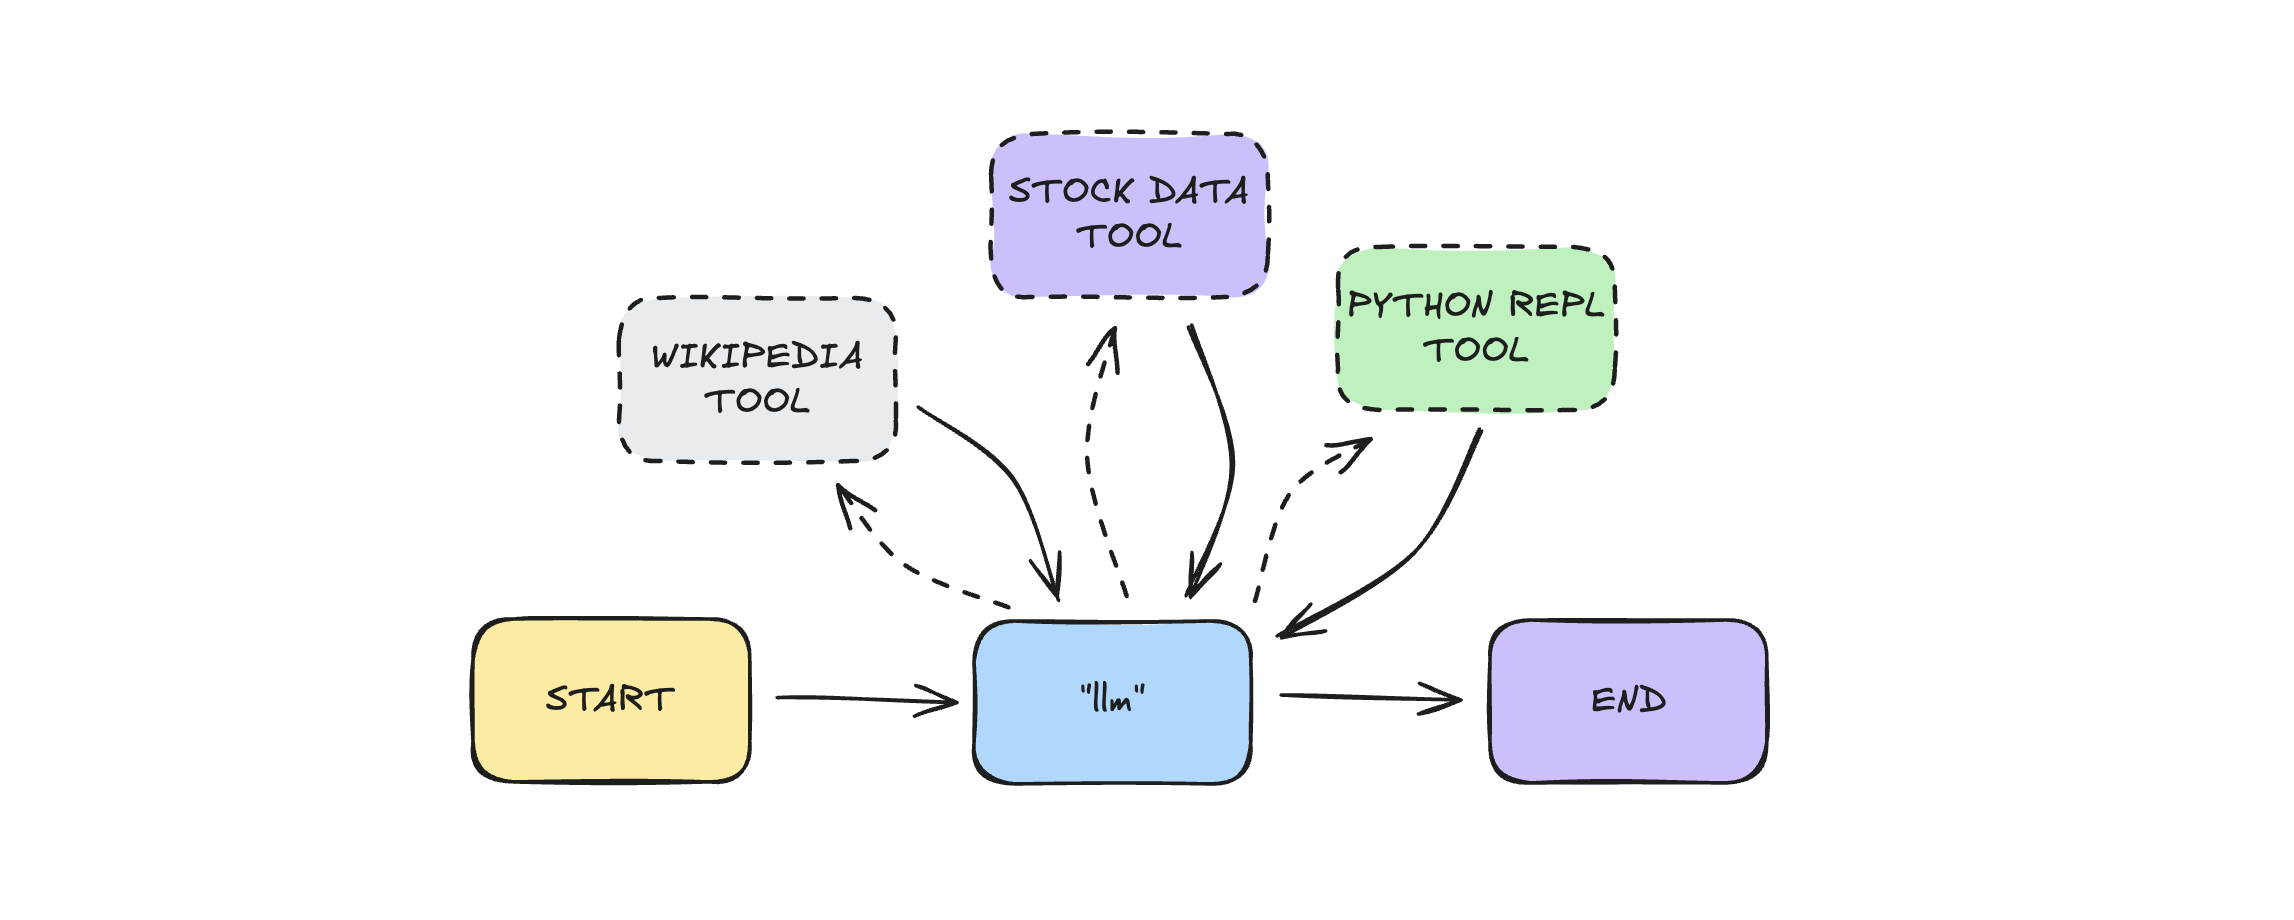

### 🔨 How can LLMs use tools?

Recall that you created three tools for the LLM to use:
1. `wikipedia_tool()`: Wikipedia search of company information.
2. `stock_data_tool()`: returns stock performance data from CSV files.
3. `python_repl_tool()`: runs Python code to generate plots.

In [ ]:
!pip install --quiet wikipedia==1.4.0 langchain-core==0.3.59 langgraph==0.5.3 langchain-openai==0.3.16 langchain-experimental==0.3.4

In [ ]:
from typing import Annotated
import wikipedia
from langchain_core.tools import tool
import pandas as pd
import os

@tool
def wikipedia_tool(
    query: Annotated[str, "The Wikipedia search to execute to find key summary information."],
):
    """Use this to search Wikipedia for factual information."""
    try:
        # Step 1: Search using query
        results = wikipedia.search(query)

        if not results:
            return "No results found on Wikipedia."

        # Step 2: Retrieve page title
        title = results[0]

        # Step 3: Fetch summary
        summary = wikipedia.summary(title, sentences=8, auto_suggest=False, redirect=True)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\nWikipedia summary: {summary}"

@tool
def stock_data_tool(
    company_ticker: Annotated[str, "The ticker symbol of the company to retrieve their stock performance data."],
    num_days: Annotated[int, "The number of business days of stock data required to respond to the user query."]
) -> str:
    """
    Use this to look-up stock performance data for companies to retrieve a table from a CSV. You may need to convert company names into ticker symbols to call this function, e.g, Apple Inc. -> AAPL, and you may need to convert weeks, months, and years, into days.
    """

    # Load the CSV for the company requested
    file_path = f"data/{company_ticker}.csv"

    if os.path.exists(file_path) is False:
        return f"Sorry, but data for company {company_ticker} is not available. Please try Apple, Amazon, Meta, Microsoft, Netflix, or Tesla."

    stock_df = pd.read_csv(file_path, index_col='Date', parse_dates=True)

    # Ensure the index is in date format
    stock_df.index = stock_df.index.date

    # Maximum num_days supported by the dataset
    max_num_days = (stock_df.index.max() - stock_df.index.min()).days

    if num_days > max_num_days:
        return "Sorry, but this time period exceeds the data available. Please reduce it to continue."

    # Get the most recent date in the DataFrame
    final_date = stock_df.index.max()

    # Filter the DataFrame to get the last num_days of stock data
    filtered_df = stock_df[stock_df.index > (final_date - pd.Timedelta(days=num_days))]

    return f"Successfully executed the stock performance data retrieval tool to retrieve the last *{num_days} days* of data for company **{company_ticker}**:\n\n{filtered_df.to_markdown()}"

from langchain_experimental.utilities import PythonREPL

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user. The chart should be displayed using `plt.show()`."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed the Python REPL tool.\n\nPython code executed:\n\`\`\`python\n{code}\n\`\`\`\n\nCode output:\n\`\`\`\n{result}\`\`\`"

### 🧰 Inspecting yout tools

These tools, when fully integrated into the graph, will be available for the chatbot to call depending on whether it determines a tool is required. But how does it do this?

Each tool created with the `@tool` decorator has a description, which is made available to the model when the tools and model are binded together.

**Print the `.name` and `.description` attributes for each `tool`. What do you notice about these descriptions?**

In [ ]:
# Loop through the tools and extract the .name and .description attributes
for tool in [wikipedia_tool, stock_data_tool, python_repl_tool]:
    print(f"The description for {tool.name}:\n> {tool.description}\n")

The docstrings in the tools became the tool descriptions! This means that a description that makes it clear to the model when and how to use the tool is crucial in the model's decision-making process.

### 🛠️ Integrating the tools

To make the LLM aware of what tools are available, we can bind them together using the `.bind_tools()` method on the LLM. This binded object is what will be invoked by the function used in the `"llm"` node.

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Add three tools to the list: wikipedia_tool, stock_data_tool, and python_repl_tool
tools = [wikipedia_tool, stock_data_tool, python_repl_tool]

llm = ChatOpenAI(model="gpt-4o-mini")

# Tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

# Invoke llm_with_tools in the llm_node() function
def llm_node(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

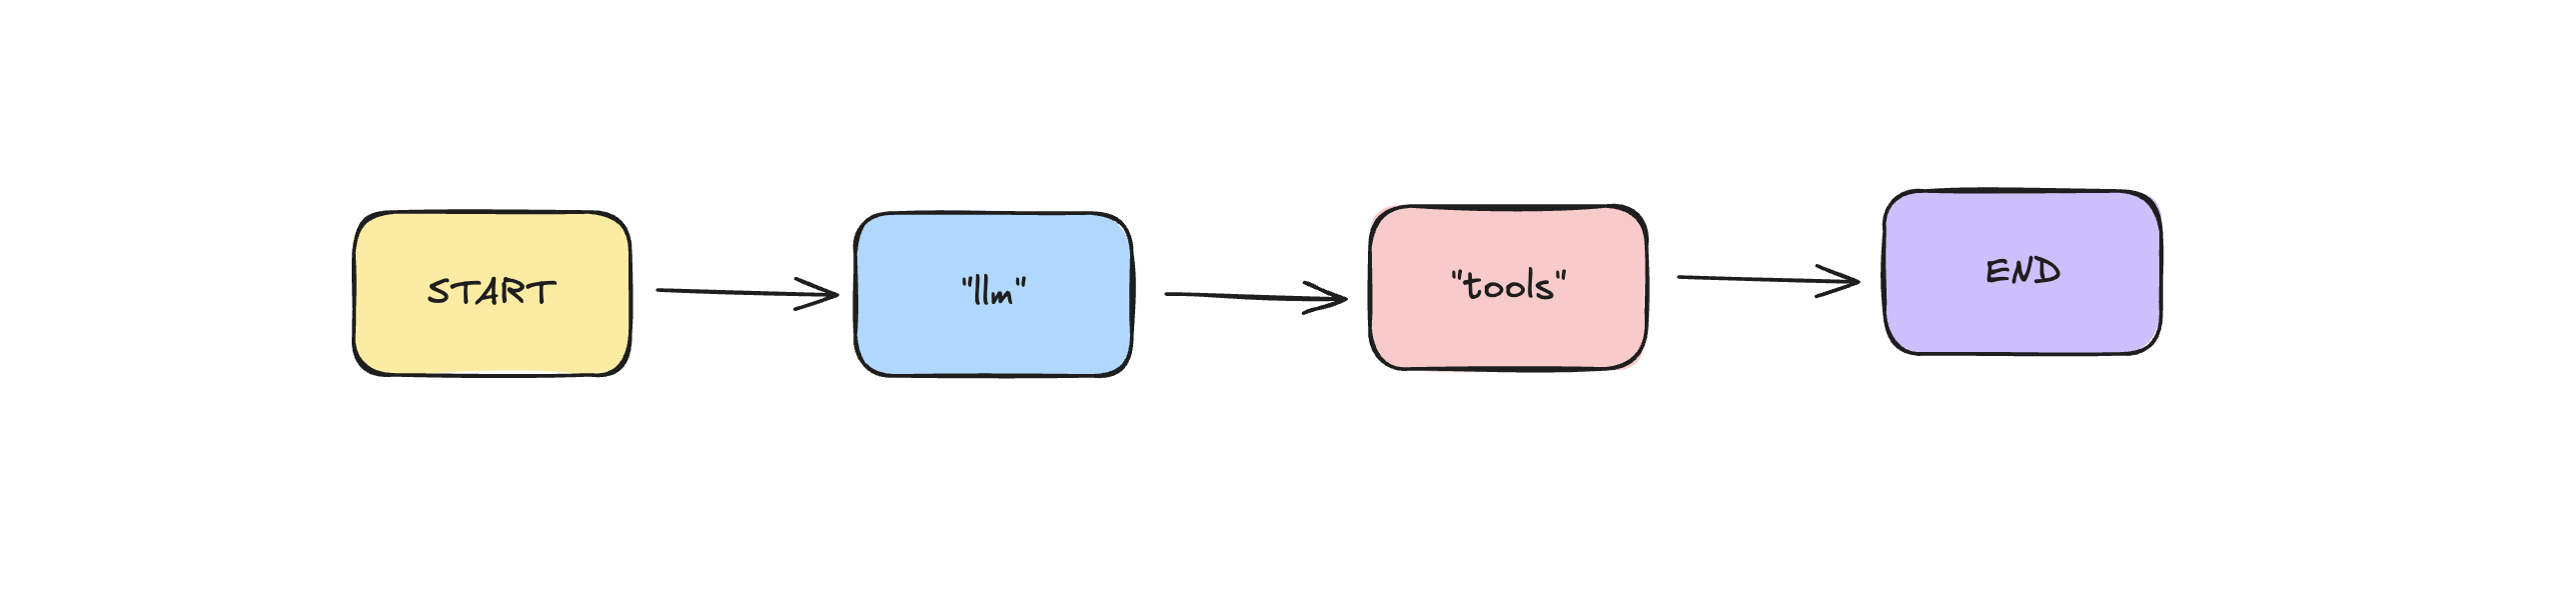

To actually run these tools in the graph, tools need to be assigned their own node.

You can create a **tool node** using the `ToolNode` class, add it to the graph with `.add_node()`, and connect the node to the graph with an edge as you did with the `"llm"` node.

In [ ]:
from langgraph.prebuilt import ToolNode

graph_builder.add_node("llm", llm_node)

# Create a tool node containing the three tools you defined
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# Create edges to represent the linear workflow
graph_builder.add_edge(START, "llm")
graph_builder.add_edge("llm", "tools")
graph_builder.add_edge("tools", END)

graph = graph_builder.compile()

Now re-run the visualization code to see your updated graph! 🚀

In [ ]:
# Visualize your graph
graph

Great job! The input is entering the chatbot node, then entering the tool node to run the tools, before finishing.

Similar to before, run the code below to begin interacting with your (now tool-powered) agent. Specifically, try running these inputs and note down what you see:

1. Tell me about Apple Inc.
2. AAPL stock price.
3. Plot an Open price time-series of AAPL.
4. My name is `<Insert your name>`.

In [ ]:
from course_helper_functions import pretty_print_messages

for chunk in graph.stream(
    {"messages": [{"role": "user", "content": "Tell me about Apple Inc."}]}
):
    pretty_print_messages(chunk)